Loading preprocessed data...
Training set: 280 samples
Test set:     120 samples

Number of raw features: 24
Missing values in training set: 0
Missing values in test set: 0

Class distribution in training set:
classification
ckd       170
notckd    110
Name: count, dtype: int64
classification
ckd       0.607143
notckd    0.392857
Name: proportion, dtype: float64

Numeric columns: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
Categorical columns: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

Encoded feature matrix shapes: train=(280, 34), test=(120, 34)
Total encoded features: 34


### BASELINE MODEL: LOGISTIC REGRESSION ###
Evaluating: Logistic Regression

Accuracy:  0.9500
Precision: 0.9744
Recall:    0.9500
F1-Score:  0.9620
ROC-AUC:   0.9862

Confusion Matrix (rows=true, cols=pred):
[[38  2]
 [ 4 76]]


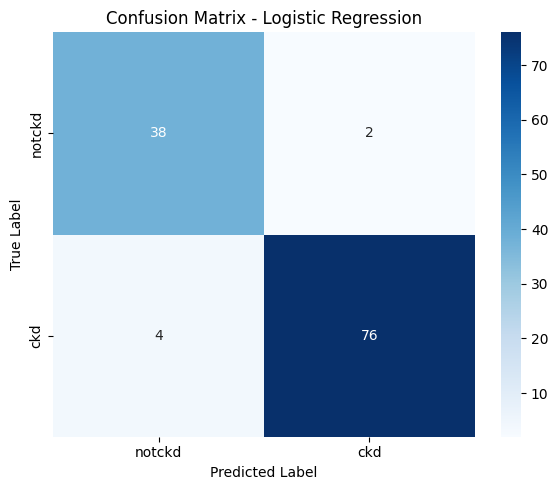


Classification Report:
              precision    recall  f1-score   support

         ckd       0.97      0.95      0.96        80
      notckd       0.90      0.95      0.93        40

    accuracy                           0.95       120
   macro avg       0.94      0.95      0.94       120
weighted avg       0.95      0.95      0.95       120



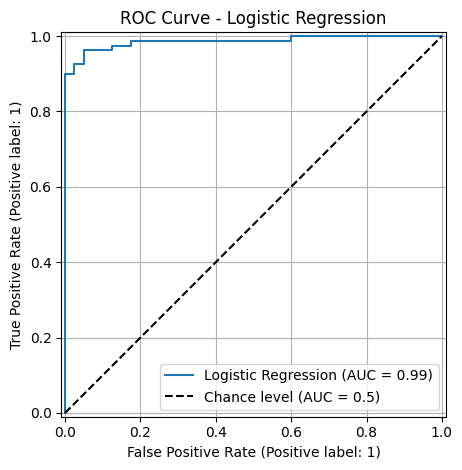


Top 10 Most Important Features (by absolute coefficient):
       Feature  Coefficient  Abs_Coefficient
3           al    -1.950356         1.950356
10        hemo     1.169021         1.169021
7           sc    -1.132198         1.132198
13        rbcc     0.862301         0.862301
29  appet_poor    -0.603124         0.603124
23     htn_yes    -0.596100         0.596100
25      dm_yes    -0.554066         0.554066
31      pe_yes    -0.538617         0.538617
28  appet_good     0.537823         0.537823
22      htn_no     0.530799         0.530799

Saved: logistic_feature_importance_memberX.csv


### MY MODEL: XGBoost ###
Hyperparameter tuning with 5-fold stratified cross-validation (XGBoost)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation F1-score: 0.9855

Top 5 XGBoost hyperparameter combinations:
 n_estimators  max_d

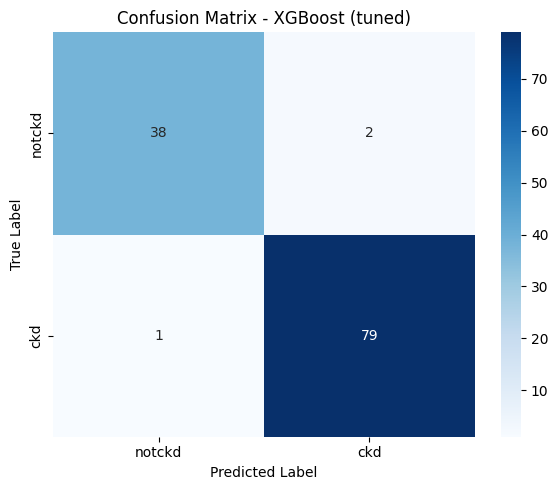


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.98      0.99      0.98        80

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



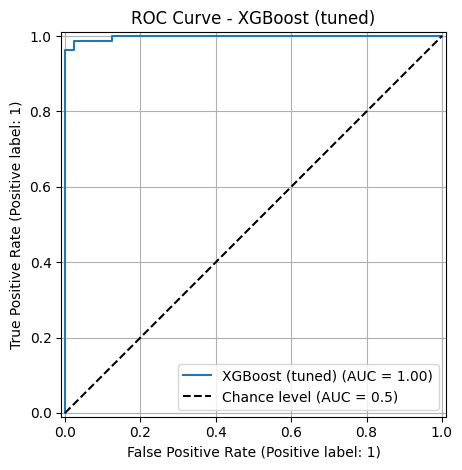



MODEL COMPARISON SUMMARY

               Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.950   0.974359  0.9500  0.962025 0.986250
    XGBoost (tuned)     0.975   0.975309  0.9875  0.981366 0.997812

Results saved to 'model_results_memberX.csv'


/tmp/ipython-input-3892243780.py:381: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(metrics, rotation=45, ha="right")


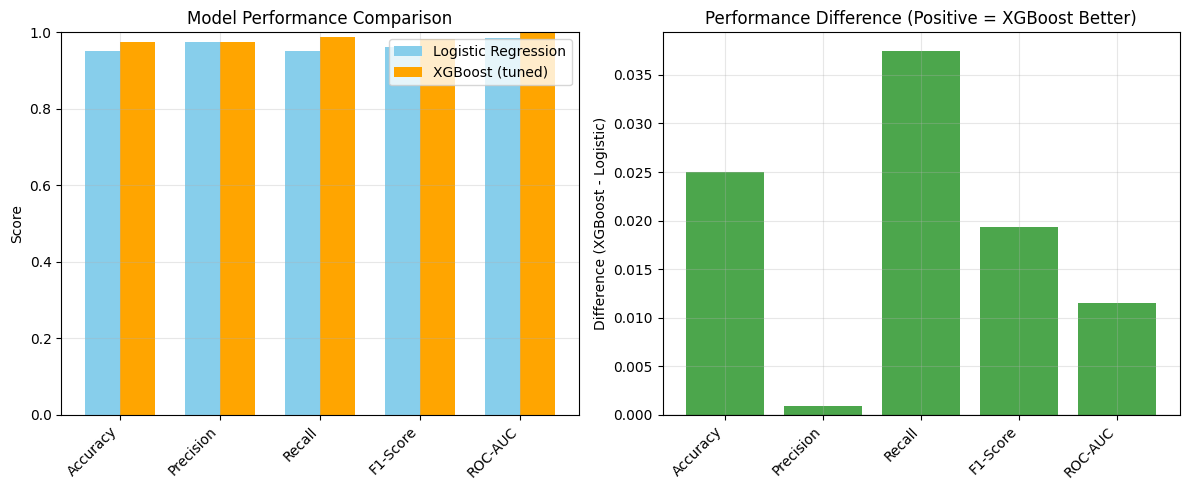


Best performing model: XGBoost (F1-Score: 0.9814)
XGBoost shows 2.0% improvement over baseline


In [5]:
"""
CKD Classification Project - Member [6905368 - Richa Suman]

Models:
- Baseline: Logistic Regression
- Main Model: XGBoost (gradient boosting)

Data:
- kidney_train.csv (from R)
- kidney_test.csv  (from R)

Assumptions:
- 'classification' column has labels 'ckd' and 'notckd'
- Features may still contain some categorical strings (e.g., 'abnormal')
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    make_scorer
)

from xgboost import XGBClassifier  # pip install xgboost


# ================================================================
# 1) LOAD PREPROCESSED DATA (FROM R)
# ================================================================

print("Loading preprocessed data...")
train_df = pd.read_csv("/content/sample_data/kidney_train.csv")
test_df = pd.read_csv("/content/sample_data/kidney_test.csv")

print(f"Training set: {train_df.shape[0]} samples")
print(f"Test set:     {test_df.shape[0]} samples\n")

# Separate features(X) and target(Y)
X_train = train_df.drop(columns=["classification"])
y_train = train_df["classification"]

X_test = test_df.drop(columns=["classification"])
y_test = test_df["classification"]

# # Create binary labels for metrics that need 0/1 (ckd = 1, notckd = 0)
y_train_binary = (y_train == "ckd").astype(int)
y_test_binary = (y_test == "ckd").astype(int)

print(f"Number of raw features: {X_train.shape[1]}")
print(f"Missing values in training set: {X_train.isnull().sum().sum()}")
print(f"Missing values in test set: {X_test.isnull().sum().sum()}")

print("\nClass distribution in training set:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print()

# ================================================================
# 1b) ENCODE CATEGORICAL FEATURES
# ================================================================
# Some columns may still be strings (e.g. 'abnormal'), which need encoding.
# We do a one-hot encoding on non-numeric columns and keep numeric columns as-is.

num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(exclude=["number"]).columns

print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

if len(cat_cols) > 0:
   # OneHotEncoder turns each category into a binary indicator feature
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

   # Fit encoder on train, transform both train and test
    X_train_cat = ohe.fit_transform(X_train[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])

    # Extract numeric part as NumPy arrays
    X_train_num = X_train[num_cols].to_numpy()
    X_test_num = X_test[num_cols].to_numpy()

    # Concatenate numeric and encoded categorical features
    X_train_encoded = np.hstack([X_train_num, X_train_cat])
    X_test_encoded = np.hstack([X_test_num, X_test_cat])

    # Build aligned feature names for interpretability
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    feature_names = list(num_cols) + list(cat_feature_names)
else:
    # If no categorical columns, just convert to NumPy and keep original names
    X_train_encoded = X_train.to_numpy()
    X_test_encoded = X_test.to_numpy()
    feature_names = X_train.columns.tolist()

print(f"\nEncoded feature matrix shapes: train={X_train_encoded.shape}, test={X_test_encoded.shape}")
print(f"Total encoded features: {len(feature_names)}\n")


# ================================================================
# 2) EVALUATION HELPER
# ================================================================
# This function centralises:
# - optional training (refit)
# - prediction
# - metric computation (accuracy, precision, recall, F1, ROC–AUC)
# - confusion matrix + ROC plot
# It supports both string labels (for Logistic) and binary labels (for XGBoost).

def safe_filename(name: str) -> str:
  """Convert a model name to a filesystem-safe string for saving figures."""
    return (
        name.replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
            .replace(",", "")
            .replace("__", "_")
    )


def evaluate_model(
    name,
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    y_test_binary,
    refit=True,
    binary_labels=False
):
    """
    Evaluate a classifier on test data.

    - If refit=False, assumes 'model' is already fitted.
    - If binary_labels=True, y_test is assumed to be 0/1 and CKD=1.
    Parameters
    ----------
    name : str
        Name used in prints and figure titles.
    model : estimator
        Any sklearn-like classifier with .fit() and .predict().
    X_train, y_train : array-like
        Training data used if refit=True.
    X_test, y_test : array-like
    Always binary 0/1; used for ROC–AUC and ROC plots (CKD=1).
    refit : bool
        If True, fit the model on (X_train, y_train) inside this function.
        If False, assume the model is already fitted (e.g. tuned XGBoost).
    binary_labels : bool
        Controls whether metrics are computed in string space or binary space.
        Returns
    -------
    dict with accuracy, precision, recall, f1, auc and the fitted model.
    """
    print("=" * 70)
    print(f"Evaluating: {name}")
    print("=" * 70)
    # Optionally train the model (for Logistic Regression)
    if refit:
        model.fit(X_train, y_train)

    # Predictions on test set
    y_pred = model.predict(X_test)

    # Decide what y_true to use and which 'positive' label to treat as CKD
    if binary_labels:
        y_true_for_metrics = y_test
        pos_label = 1
    else:
      # Logistic case: y_test string labels, positive is "ckd"
        y_true_for_metrics = y_test
        pos_label = "ckd"

    # Probabilities / scores for ROC–AUC + ROC curve
    y_proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        # if model was trained on 0/1, positive class is index 1
        if not binary_labels and "ckd" in getattr(model, "classes_", []):
            pos_index = list(model.classes_).index("ckd")
        else:
            pos_index = 1
        y_proba = proba[:, pos_index]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)

    # Standard classification metrics
    accuracy = accuracy_score(y_true_for_metrics, y_pred)
    precision = precision_score(y_true_for_metrics, y_pred, pos_label=pos_label)
    recall = recall_score(y_true_for_metrics, y_pred, pos_label=pos_label)
    f1 = f1_score(y_true_for_metrics, y_pred, pos_label=pos_label)

    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

     # ROC–AUC always uses y_test_binary (0/1 with CKD=1)
    if y_proba is not None:
        auc = roc_auc_score(y_test_binary, y_proba)
        print(f"ROC-AUC:   {auc:.4f}")
    else:
        auc = None
        print("ROC-AUC:   Not available")

    # Confusion matrix display labels
    # - for Logistic: labels are "notckd"/"ckd"
    # - for XGBoost: labels are 0/1 but we relabel axes for readability
    if binary_labels:
        labels = [0, 1]
        xticks = ["notckd", "ckd"]
        yticks = ["notckd", "ckd"]
    else:
        labels = ["notckd", "ckd"]
        xticks = labels
        yticks = labels

    cm = confusion_matrix(y_true_for_metrics, y_pred, labels=labels)
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)

    # Visualise confusion matrix as heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=xticks,
        yticklabels=yticks
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{safe_filename(name)}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(y_true_for_metrics, y_pred))

    # ROC curve using binary labels and predicted probabilities
    if y_proba is not None:
        RocCurveDisplay.from_predictions(
            y_test_binary,
            y_proba,
            name=name,
            plot_chance_level=True
        )
        plt.title(f"ROC Curve - {name}")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"roc_curve_{safe_filename(name)}.png", dpi=300, bbox_inches="tight")
        plt.show()

    return {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }


# ================================================================
# 3) LOGISTIC REGRESSION (BASELINE)
# ================================================================
# Simple, interpretable baseline using string labels ("ckd"/"notckd").

print("\n### BASELINE MODEL: LOGISTIC REGRESSION ###")

logistic_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42,
    solver="liblinear"
)

logistic_results = evaluate_model(
    "Logistic Regression",
    logistic_model,
    X_train_encoded, y_train,        # string labels
    X_test_encoded, y_test,
    y_test_binary,
    refit=True,
    binary_labels=False
)

# Inspect feature importance via model coefficients
print("\nTop 10 Most Important Features (by absolute coefficient):")
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": logistic_results["model"].coef_[0]
})
feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values("Abs_Coefficient", ascending=False)
print(feature_importance.head(10))

feature_importance.to_csv("logistic_feature_importance_memberX.csv", index=False)
print("\nSaved: logistic_feature_importance_memberX.csv")


# ================================================================
# 4) XGBOOST (MAIN MODEL)
# ================================================================
## Non-linear model tuned with GridSearchCV using binary labels (0/1).

print("\n\n### MY MODEL: XGBoost ###")

# Imbalance ratio for XGBoost (use binary y)
pos_weight = (y_train_binary == 0).sum() / (y_train_binary == 1).sum()

# Small parameter grid for demonstration; can be extended if time/resources allow
param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

print("Hyperparameter tuning with 5-fold stratified cross-validation (XGBoost)...")

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=pos_weight,
    n_jobs=-1
)

# # Cross-validation scoring uses binary labels and F1 with positive class = 1
f1_ckd_scorer_bin = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=f1_ckd_scorer_bin,
    n_jobs=-1,
    verbose=1
)
# IMPORTANT: fit on encoded features and binary labels
grid_search_xgb.fit(X_train_encoded, y_train_binary)

print(f"\nBest XGBoost parameters: {grid_search_xgb.best_params_}")
print(f"Best cross-validation F1-score: {grid_search_xgb.best_score_:.4f}")

# Show top 5 parameter combinations for reporting
cv_results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
top_5_xgb = cv_results_xgb.nsmallest(5, "rank_test_score")[
    ["param_n_estimators", "param_max_depth", "param_learning_rate", "mean_test_score", "std_test_score"]
]
top_5_xgb.columns = ["n_estimators", "max_depth", "learning_rate", "Mean F1", "Std F1"]
print("\nTop 5 XGBoost hyperparameter combinations:")
print(top_5_xgb.to_string(index=False))
print()

# Best tuned XGBoost model (already fitted on full training set)
best_xgb = grid_search_xgb.best_estimator_

# Evaluate on binary labels; do NOT refit
xgb_results = evaluate_model(
    "XGBoost (tuned)",
    best_xgb,
    X_train_encoded, y_train_binary,     # y_train_binary only used if refit=True; here False
    X_test_encoded, y_test_binary,       # evaluate on binary labels
    y_test_binary,
    refit=False,
    binary_labels=True
)


# ================================================================
# 5) MODEL COMPARISON SUMMARY
# ================================================================
# Compare Logistic vs XGBoost on key metrics and visualise differences.

print("\n\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost (tuned)"],
    "Accuracy": [logistic_results["accuracy"], xgb_results["accuracy"]],
    "Precision": [logistic_results["precision"], xgb_results["precision"]],
    "Recall": [logistic_results["recall"], xgb_results["recall"]],
    "F1-Score": [logistic_results["f1"], xgb_results["f1"]],
    "ROC-AUC": [logistic_results["auc"], xgb_results["auc"]]
})

print("\n", comparison.to_string(index=False))
comparison.to_csv("model_results_memberX.csv", index=False)
print("\nResults saved to 'model_results_memberX.csv'")

# Side-by-side bar plots and difference plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
lr_values = comparison.iloc[0, 1:].values
xgb_values = comparison.iloc[1, 1:].values

x = np.arange(len(metrics))
width = 0.35

# Absolute scores
ax[0].bar(x - width/2, lr_values, width, label="Logistic Regression", color="skyblue")
ax[0].bar(x + width/2, xgb_values, width, label="XGBoost (tuned)", color="orange")
ax[0].set_ylabel("Score")
ax[0].set_title("Model Performance Comparison")
ax[0].set_xticks(x)
ax[0].set_xticklabels(metrics, rotation=45, ha="right")
ax[0].legend()
ax[0].set_ylim([0, 1])
ax[0].grid(True, alpha=0.3)

# Differences (XGBoost - Logistic); positive values mean XGBoost is better
differences = xgb_values - lr_values
colors = ["green" if d > 0 else "red" for d in differences]
ax[1].bar(metrics, differences, color=colors, alpha=0.7)
ax[1].axhline(y=0, color="black", linestyle="-", linewidth=0.8)
ax[1].set_ylabel("Difference (XGBoost - Logistic)")
ax[1].set_title("Performance Difference (Positive = XGBoost Better)")
ax[1].set_xticklabels(metrics, rotation=45, ha="right")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison_memberX.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 70)
if xgb_results["f1"] > logistic_results["f1"]:
    print(f"Best performing model: XGBoost (F1-Score: {xgb_results['f1']:.4f})")
    improvement = ((xgb_results["f1"] - logistic_results["f1"]) / logistic_results["f1"]) * 100
    print(f"XGBoost shows {improvement:.1f}% improvement over baseline")
else:
    print(f"Best performing model: Logistic Regression (F1-Score: {logistic_results['f1']:.4f})")
    print("Baseline model performs as well or better than XGBoost")
